# Binary classification using the Titanic dataset

One of the classic public datasets used to demonstrate binary classification is the Titanic dataset, which lists the passengers aboard the RMS Titanic when it sank on April 15, 1912. The dataset includes the name of each passenger as well as other information such as the fare class, the fare price, the person's age and gender, and whether that person survived the sinking of the ship. In this example, we will build a binary-classification model that predicts whether a passenger will survive. We will use logistic regression as the basis for the model.

![](Images/titanic.png)

## Load and prepare the dataset

The first step is to load the dataset and prepare it for training a machine-learning model. One of the reasons the Titanic dataset is popular is that it provides ample opportunity for data scientists to practice their data-cleaning skills.

In [1]:
import pandas as pd

df = pd.read_csv('Data/titanic.csv')
df.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


We'll drop columns such as "PassengerId" and "Name" that have no bearing on the outcome. We will also drop the "Fare" column because there is colinearity between that column and the "Pclass" column. Finally, we will one-hot-encode the "Sex" and "Pclass" columns, and remove rows containing missing values.

In [3]:
df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin', 'Embarked', 'Fare'], axis=1, inplace=True)
df = pd.get_dummies(df, columns=['Sex', 'Pclass'])
df.dropna(inplace=True)
df.head()

,Survived,Age,SibSp,Parch,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3
0,0,22.0,1,0,0,1,0,0,1
1,1,38.0,1,0,1,0,1,0,0
2,1,26.0,0,0,1,0,0,0,1
3,1,35.0,1,0,1,0,1,0,0
4,0,35.0,0,0,0,1,0,0,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 714 entries, 0 to 890
Data columns (total 9 columns):
Survived      714 non-null int64
Age           714 non-null float64
SibSp         714 non-null int64
Parch         714 non-null int64
Sex_female    714 non-null uint8
Sex_male      714 non-null uint8
Pclass_1      714 non-null uint8
Pclass_2      714 non-null uint8
Pclass_3      714 non-null uint8
dtypes: float64(1), int64(3), uint8(5)
memory usage: 31.4 KB


Now let's see which input variables have the most influence on the outcome.

In [5]:
df.corr()["Survived"].sort_values(ascending=False)

Survived      1.000000
Sex_female    0.538826
Pclass_1      0.301831
Parch         0.093317
Pclass_2      0.084753
SibSp        -0.017358
Age          -0.077221
Pclass_3     -0.337587
Sex_male     -0.538826
Name: Survived, dtype: float64

The number of parents accompanying the passenger ("Parch") and the number of siblings ("SibSp") have little effect on the outcome, so we'll remove those columns.

In [6]:
df.drop(['Parch', 'SibSp'], axis=1, inplace=True)
df.head()

,Survived,Age,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3
0,0,22.0,0,1,0,0,1
1,1,38.0,1,0,1,0,0
2,1,26.0,1,0,0,0,1
3,1,35.0,1,0,1,0,0
4,0,35.0,0,1,0,0,1


The final step is to split the data into two datasets: one for training and one for testing. We'll use a stratified split to create a balanced distribution of samples in the training dataset and the testing dataset.

In [7]:
from sklearn.model_selection import train_test_split

x = df.drop('Survived', axis=1)
y = df['Survived']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=0)

## Build and train a model

Our classifier will use logistic regression. One of the advantages of logistic regression is that it will not only make predictions, it will yield probabilities as well.

In [8]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(random_state=0)
model.fit(x_train, y_train)

LogisticRegression(random_state=0)

Get an accuracy score.

In [9]:
model.score(x_test, y_test)

0.8321678321678322

Cross-validate the model using five folds.

In [10]:
from sklearn.model_selection import cross_validate

scores = cross_validate(model, x, y, cv=5)
print(scores['test_score'].mean())

0.7857480547621394


Use a confusion matrix to see how the model performed during testing.

In [11]:
from sklearn.metrics import confusion_matrix

y_predicted = model.predict(x_test)
confusion_matrix(y_test, y_predicted)

array([[78,  7],
       [17, 41]], dtype=int64)

Print a classification report to view precision, recall, and other metrics.

In [12]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.82      0.92      0.87        85
           1       0.85      0.71      0.77        58

    accuracy                           0.83       143
   macro avg       0.84      0.81      0.82       143
weighted avg       0.83      0.83      0.83       143



Finally, visualize the model's accuracy by plotting an ROC curve.

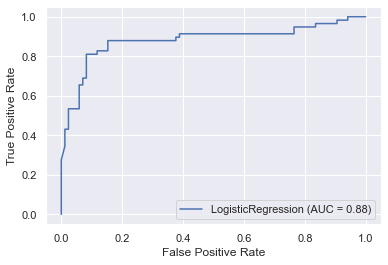

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.metrics import plot_roc_curve

plot_roc_curve(model, x_test, y_test)

## Use the model to make predictions

Now use the model to predict whether a 30-year-old female traveling in first class will survive the voyage.

In [14]:
female = [[30, 1, 0, 1, 0, 0]]
model.predict(female)[0]

1

More to the point, what is the probability that a 30-year-old female traveling in first class will survive?

In [15]:
probability = model.predict_proba(female)[0][1]
print('Probability of survival: {:.1%}'.format(probability))

Probability of survival: 91.6%


How about a 60-year-old male traveling in third class?

In [16]:
male = [[60, 0, 1, 0, 0, 1]]
probability = model.predict_proba(male)[0][1]
print('Probability of survival: {:.1%}'.format(probability))

Probability of survival: 2.9%
